In [1]:
import keras
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ELU
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Input, LSTM, RepeatVector, Lambda,Bidirectional,CuDNNLSTM
from keras import regularizers
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import objectives
import numpy as np
import matplotlib.pyplot as plt
import time
from keras.regularizers import l2
from keras import layers, models

Using TensorFlow backend.


In [2]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [3]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [4]:
y_train_valid -= 769
y_test = y_test-769

In [5]:
def rnn(input_shape):
    model = Sequential()

    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Bidirectional(LSTM(64, recurrent_dropout=0.25, return_sequences=True,input_shape=input_shape, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01))))    
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))    
    model.add(Dense(32,activation='elu'))
    model.add(Dropout(0.5))    
    model.add(Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.02)))    
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['acc'])
    return model


In [6]:
def train(model, x_train, y_train, x_test, y_test):
    history = model.fit(x_train,y_train,batch_size=50,epochs=30,shuffle=True,validation_split = 0.2)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
    return model

In [7]:
def predict(model,x_test,y_test):
    y_pred = model.predict(x_test)
    confusion_matrix = np.zeros((4, 4))
    accuracy = 0
    for i in range(y_pred.shape[0]):
        label_true = np.argmax(y_test[i])
        label_pred = np.argmax(y_pred[i])
        confusion_matrix[label_true, label_pred] += 1
        if label_true == label_pred:
            accuracy += 1
    accuracy /= x_test.shape[0]
    return accuracy,confusion_matrix

In [8]:
# Sliding windows on original data
window_length = 10
hop_length = 5
n_windows =(1000-window_length) // hop_length + 1 

print("windows number:", n_windows)

windows number: 199


In [9]:
def sliding(data): #by default data's dimesnion is 3
    data_new = np.zeros((data.shape[0],n_windows,window_length*22)) #local variable
    for i in range(data.shape[0]):
        raw = data[i].transpose(1,0)
        for j in range(n_windows):
            data_new[i,j] = raw[j*hop_length:j*hop_length+window_length].flatten()
    return data_new


In [11]:
x_train = X_train_valid[:,:22,:].astype('float32')
x_test = X_test[:,:22,:].astype('float32')
y_train = y_train_valid
y_test = y_test
x_train = sliding(x_train)
x_test = sliding(x_test)

print("x training shape after sliding:",x_train.shape)

x training shape after sliding: (2115, 199, 220)


Train on 1692 samples, validate on 423 samples
Epoch 1/30
1692/1692 [==============================] - 15s 9ms/step - loss: 15.3681 - acc: 0.2831 - val_loss: 13.6143 - val_acc: 0.3428
Epoch 2/30
1692/1692 [==============================] - 14s 8ms/step - loss: 13.4278 - acc: 0.3735 - val_loss: 12.5042 - val_acc: 0.2931
Epoch 3/30
1692/1692 [==============================] - 14s 8ms/step - loss: 12.1887 - acc: 0.3942 - val_loss: 11.4408 - val_acc: 0.3522
Epoch 4/30
1692/1692 [==============================] - 14s 8ms/step - loss: 11.0540 - acc: 0.4657 - val_loss: 10.5892 - val_acc: 0.3783
Epoch 5/30
1692/1692 [==============================] - 14s 8ms/step - loss: 10.1358 - acc: 0.4770 - val_loss: 9.9230 - val_acc: 0.3239
Epoch 6/30
1692/1692 [==============================] - 14s 8ms/step - loss: 9.4145 - acc: 0.5035 - val_loss: 9.2375 - val_acc: 0.3641
Epoch 7/30
1692/1692 [==============================] - 14s 8ms/step - loss: 8.6720 - acc: 0.5656 - val_loss: 8.7092 - val_acc: 0.3853

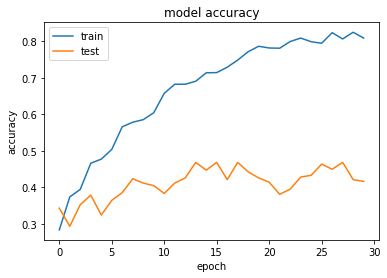

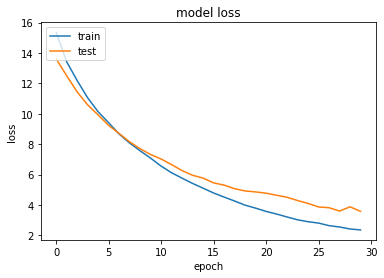

0.4672686230248307
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 199, 128)          145920    
_________________________________________________________________
batch_normalization_1 (Batch (None, 199, 128)          512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 199, 128)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 199, 128)          98816     
_________________________________________________________________
batch_normalization_2 (Batch (None, 199, 128)          512       
_________________________________________________________________
flatten_1 (Flatten)          (None, 25472)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None,

In [12]:
def RNN(x_train,y_train,x_test,y_test):
    train_example = x_train
    test_example = x_test
    train_target = keras.utils.to_categorical(y_train, 4)
    test_target = keras.utils.to_categorical(y_test, 4)
    
    model = rnn(train_example[0].shape)
    model = train(model,train_example,train_target,test_example,test_target)
    acc,c_matrix = predict(model,test_example,test_target)
    print(acc)
    model.summary()
    return acc

acc = RNN(x_train,y_train,x_test,y_test)